In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

# Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import tqdm

In [2]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [3]:
device = torch.device("cuda:0")

# Load Data

In [5]:
file_path = '/content/drive/MyDrive/Pal-ette/preprocessed_data'
df = pd.read_csv(os.path.join(file_path, 'merged_7-emotions_morphs.csv'))
df.head()

,emotion,preprocessed,morphs
0,분노,"자기야 너무 화가나 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 봉투를 파...",자기야 너무 화가 퇴근 후 집 들어왔는데 키우는 반려견 휴지통 봉투 파헤쳐놨어 오늘...
1,분노,오늘 고생하고 집에왔는데 장면을 보고 기분이 안좋았겠다 자기가 화나니까 나도 속상...,오늘 고생 집 왔는데 장면 보고 기분 안좋았겠다 자기 화나니까 나도 속상하고 기분 ...
2,분노,"내가 출근 전에 청소를 다했었거든 그런데, 집이 더럽게 되었어 청소를 할 생각하...",내 출근 전 청소 다 했었거든 집 더럽게 되었어 청소 할 생각 하니 너무 기분 안좋...
3,분노,"나였어도, 아침에 내서 치웠는데, 저녁에 청소를 해야 하면 기분이 안좋을 같아 나...",나였어도 아침 내서 치웠는데 저녁 청소 해야 하면 기분 안좋을 같아 나도 키우는 강...
4,분노,강아지를 데려온지 안되서 그런지 힘든게 한두개가 아니야 밤에는 짖어서 잠을 설치기...,강아지 데려온지 안되서 그런지 힘든게 개 아니야 밤 짖어서 잠 설치 기도 해 휴지통...


In [6]:
df[df['preprocessed'].isna()]

,emotion,preprocessed,morphs


In [7]:
df[df['morphs'].isna()]

,emotion,preprocessed,morphs
461003,중립,50! 25!,NaN
463839,중립,어? 아,NaN
467571,중립,아네?,NaN
483326,중립,야! 어,NaN
485648,중립,아네?,NaN
488555,중립,야!! 어?,NaN
502953,슬픔,아,NaN
502955,슬픔,하,NaN
503451,슬픔,하,NaN
503470,슬픔,어휴,NaN


In [8]:
df.dropna(subset = ['morphs'], inplace=True)
df[df['morphs'].isna()]

,emotion,preprocessed,morphs


In [9]:
df.reset_index(drop=True, inplace=True)
df

,emotion,preprocessed,morphs
0,분노,"자기야 너무 화가나 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 봉투를 파...",자기야 너무 화가 퇴근 후 집 들어왔는데 키우는 반려견 휴지통 봉투 파헤쳐놨어 오늘...
1,분노,오늘 고생하고 집에왔는데 장면을 보고 기분이 안좋았겠다 자기가 화나니까 나도 속상...,오늘 고생 집 왔는데 장면 보고 기분 안좋았겠다 자기 화나니까 나도 속상하고 기분 ...
2,분노,"내가 출근 전에 청소를 다했었거든 그런데, 집이 더럽게 되었어 청소를 할 생각하...",내 출근 전 청소 다 했었거든 집 더럽게 되었어 청소 할 생각 하니 너무 기분 안좋...
3,분노,"나였어도, 아침에 내서 치웠는데, 저녁에 청소를 해야 하면 기분이 안좋을 같아 나...",나였어도 아침 내서 치웠는데 저녁 청소 해야 하면 기분 안좋을 같아 나도 키우는 강...
4,분노,강아지를 데려온지 안되서 그런지 힘든게 한두개가 아니야 밤에는 짖어서 잠을 설치기...,강아지 데려온지 안되서 그런지 힘든게 개 아니야 밤 짖어서 잠 설치 기도 해 휴지통...
...,...,...,...
519680,상처,너무 지친다,너무 지친다
519681,상처,갈수록 지쳐요,갈수록 지쳐요
519682,상처,그 짓도 한 두 번이지,그 짓도 한 두 번
519683,상처,이제 저도 한계가 온 거 같아요,이제 저 한계 온 거 같아요


In [10]:
df_ang = df[df['emotion']=='분노'].sample(15000)
df_joy = df[df['emotion']=='기쁨'].sample(15000)
df_sad = df[df['emotion']=='슬픔'].sample(15000)
df_uns = df[df['emotion']=='불안'].sample(15000)
df_sca = df[df['emotion']=='상처'].sample(15000)
df_fru = df[df['emotion']=='당황'].sample(15000)
df_neu = df[df['emotion']=='중립'].sample(15000)

df_part = pd.concat([df_ang, df_joy, df_sad, df_uns, df_sca, df_fru, df_neu])
df_part['emotion'].value_counts()

emotion
분노    15000
기쁨    15000
슬픔    15000
불안    15000
상처    15000
당황    15000
중립    15000
Name: count, dtype: int64

### LabelEncoder

In [11]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_part['label'] = LE.fit_transform(df_part['emotion'])

labels = LE.classes_
print(len(labels), labels)

7 ['기쁨' '당황' '분노' '불안' '상처' '슬픔' '중립']


In [12]:
df_part['emotion'].value_counts()

emotion
분노    15000
기쁨    15000
슬픔    15000
불안    15000
상처    15000
당황    15000
중립    15000
Name: count, dtype: int64

### Re-arrange Data

In [13]:
data_list = []
for q, label in zip(df_part['preprocessed'], df_part['label']):
  data = []
  data.append(q)
  data.append(label)
  data_list.append(data)

### Train / Test Split

In [15]:
from sklearn.model_selection import train_test_split
train_, test = train_test_split(data_list, test_size=15000, random_state=0, shuffle=True)
train, valid = train_test_split(train_, test_size=15000, random_state=0, shuffle=True)

print(len(train), len(valid), len(test))

75000 15000 15000


# KoBERTTokenizer

In [16]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### token length

In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [18]:
tok = tokenizer.tokenize
max_len = 300

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
validset = BERTDataset(valid, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_valid = [d[1] for d in validset]
token_len_test = [d[1] for d in testset]

In [19]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_valid), max(token_len_valid))
print(min(token_len_test), max(token_len_test))

4 298
3 180
4 194


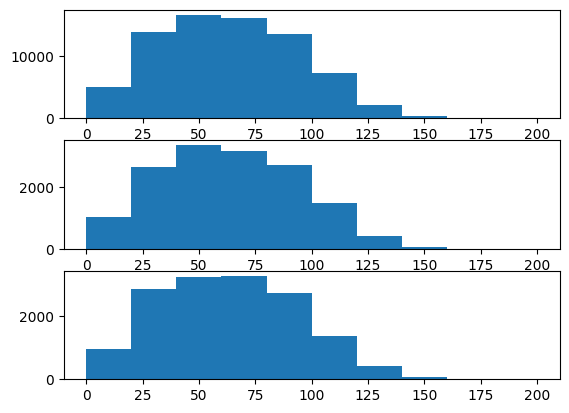

In [20]:
fig, ax = plt.subplots(3, 1)

ax[0].hist(token_len_train, range=[0, 200])
ax[1].hist(token_len_valid, range=[0, 200])
ax[2].hist(token_len_test, range=[0, 200])

plt.show()

### Tokenization

In [21]:
tok = tokenizer.tokenize
max_len = 64
batch_size = 64

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False)
validset = BERTDataset(valid, 0, 1, tok, vocab, max_len, True, False)
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False)

In [22]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

### KoBERT Model

In [23]:
# get KoBERT model
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [24]:
# set params
num_classes = len(labels)
num_epochs = 20
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5
dr_rate=0.4

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

        self.classifier = nn.Linear(hidden_size , num_classes)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, out = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(out)
        return self.classifier(out)

In [26]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=dr_rate).to(device)

In [27]:
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [28]:
for i, (name, param) in enumerate(model.named_parameters()):

    if 'pooler' in name:
      print(i, name)
      print('END')
      break

    param.requires_grad = False

197 bert.pooler.dense.weight
END


In [29]:
for i, (name, param) in enumerate(model.named_parameters()):

    if param.requires_grad:
      print(i, name, param)
      break

197 bert.pooler.dense.weight Parameter containing:
tensor([[ 0.0077,  0.0124, -0.0042,  ..., -0.0019, -0.0073,  0.0119],
        [-0.0020, -0.0003, -0.0064,  ..., -0.0028,  0.0116, -0.0125],
        [ 0.0028,  0.0205, -0.0122,  ..., -0.0003, -0.0050, -0.0033],
        ...,
        [ 0.0074,  0.0006,  0.0059,  ..., -0.0053, -0.0033,  0.0135],
        [-0.0034,  0.0039,  0.0098,  ..., -0.0116, -0.0011, -0.0080],
        [ 0.0095,  0.0065,  0.0075,  ...,  0.0149,  0.0100,  0.0130]],
       device='cuda:0', requires_grad=True)


In [30]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [31]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # correct_bias=False
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [33]:
!nvidia-smi

Mon Apr 22 05:44:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W /  70W |    525MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='upper right')

  plt.show()

epoch 20 train acc 0.44107866589468553 valid acc 0.4691267730496454


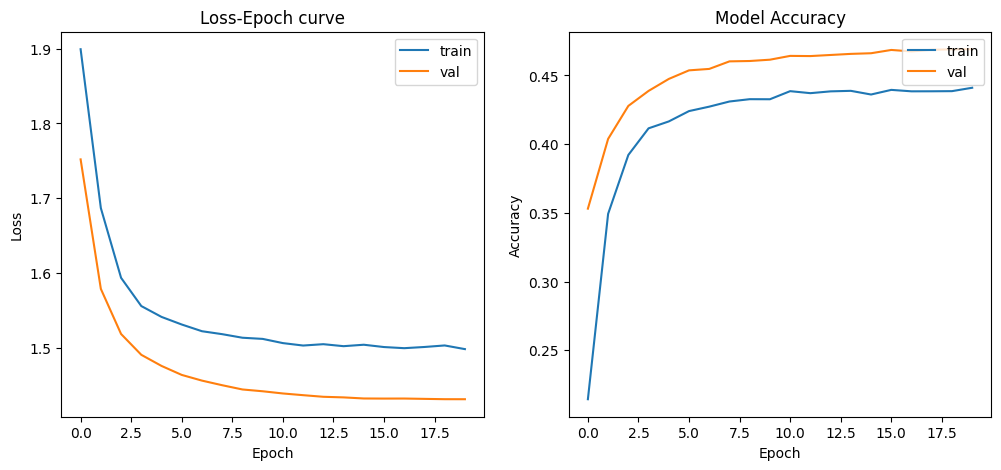

In [35]:
best_val_acc, best_val_loss = 0.0, 100.0
best_model = None

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []

for e in range(num_epochs):
    print(f"===== {e+1} Epoch =====")
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    print("epoch {} train acc {} loss {}".format(e+1, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e+1, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} valid acc {}".format(e+1, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      mean_val_loss = mean_val_loss
      best_model = deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'KoBERT_best.pt')

In [ ]:
model_path = '/content/drive/MyDrive/Pal-ette/trained_models'

In [ ]:
best_model

In [ ]:
torch.save(best_model, os.path.join(model_path, 'KoBERT_7emotions_0422.pt'))

In [ ]:
config = {"model_baseline":BERTClassifier, "torch.dataset":BERTDataset, "labels":labels}

In [ ]:
import pickle
with open('KoBERT-config.pickle','wb') as fw:
    pickle.dump(config, fw)

##### Evaluation

In [37]:
pre_trained_model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=dr_rate).to(device)
pre_trained_model.load_state_dict(torch.load('KoBERT_best.pt'))
# pre_trained_model.load_state_dict(torch.load(os.path.join(model_path, 'KoBERT_best.pt')))

<All keys matched successfully>

In [38]:
def get_label(pred, label):
  max_vals, max_indices = torch.max(pred, 1)
  prediction = [labels[int(idx_p)] for idx_p in max_indices]
  target = [labels[int(idx_l)] for idx_l in label]

  return target, prediction

In [39]:
model.eval()
val_acc = 0.0

target, pred = [], []

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length = valid_length
  label = label.long().to(device)
  out = model(token_ids, valid_length, segment_ids)
  val_acc += calc_accuracy(out, label)
  real, prediction = get_label(out, label)
  target = target + real
  pred = pred + prediction
tot_acc = val_acc / (batch_id+1)
print(f"Test acc {tot_acc}")

  0%|          | 0/235 [00:00<?, ?it/s]

Test acc 0.4533909574468085


In [ ]:
def get_model(bertmodel, baseline_model, model_file, num_classes):
  pre_trained_model = baseline_model(bertmodel, num_classes=num_classes, dr_rate=0.5).to(device)
  pre_trained_model.load_state_dict(torch.load(model_file))

  return pre_trained_model

def evaluation(model, text, tokenizer, vocab, labels):

  text = (text, )
  tok = tokenizer.tokenize
  trainset = BERTDataset(text, 0, 1, tok, vocab, 64, True, False)

  model.eval()
  token_ids = trainset[0].long().to(device)
  segment_ids = trainset[2].long().to(device)
  valid_length = trainset[1]
  out = model(token_ids, valid_length, segment_ids)

  return labels[out.argmax().item()]

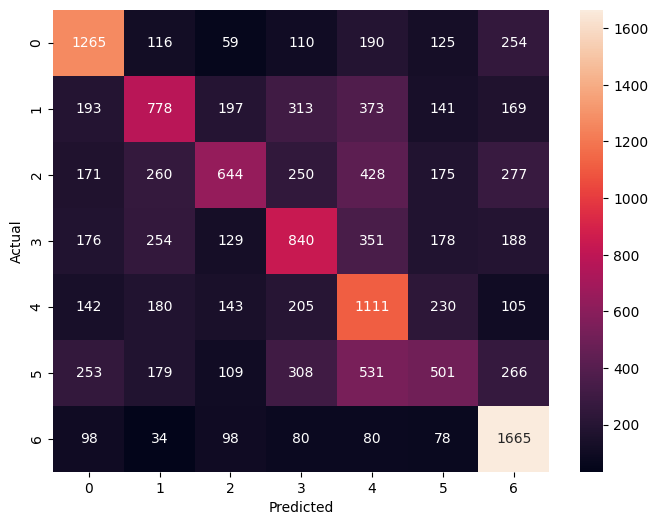

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cf_matrix = confusion_matrix(target, pred)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [45]:
labels

array(['기쁨', '당황', '분노', '불안', '상처', '슬픔', '중립'], dtype=object)

In [48]:
print(classification_report(target, pred))

              precision    recall  f1-score   support

          기쁨       0.55      0.60      0.57      2119
          당황       0.43      0.36      0.39      2164
          분노       0.47      0.29      0.36      2205
          불안       0.40      0.40      0.40      2116
          상처       0.36      0.53      0.43      2116
          슬픔       0.35      0.23      0.28      2147
          중립       0.57      0.78      0.66      2133

    accuracy                           0.45     15000
   macro avg       0.45      0.45      0.44     15000
weighted avg       0.45      0.45      0.44     15000

